##Omid Jafaei

##Mohammad Jawad Amin

##Mohammad Reza Baqeri

In [1]:
!mkdir /content/Codes
%cd /content/Codes

/content/Codes


# Import libraries

In [2]:
from google.colab import files

uploaded = files.upload()

Saving utilityG.py to utilityG.py


In [3]:
from transformers import AutoTokenizer, set_seed
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np
import utilityG
import random
import torch
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparameters

In [5]:
model_name = 'bert-base-uncased'

num_epochs = 5

learning_rate = 2e-4

n_class_dataset = 6

p_dropout = 0.1

batch_size = 64

d_in = 100

d_out = 768

Seed = 42

max_length = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lambda_sup = 1.2
lambda_feat = 1.2

# GAN-Bert Model

## Generator_1 Network

### Input

The class takes a latent vector `latent_vector` of size `(batch_size, input_dim)` as input. This vector represents the input noise for the generator.

### Forward Method

The forward method applies the following operations sequentially:

1. Linear transformation (`layer1`): Takes the `latent_vector` as input and produces an intermediate output.
2. Leaky ReLU Activation: Applies leaky rectified linear unit activation to the intermediate output.
3. Dropout: Applies dropout to the output of the leaky ReLU activation.
4. Linear transformation (`layer2`): Produces the final output vector `v_G` for the generator.

The final output `v_G` has a size of `(batch_size, output_dim)`.





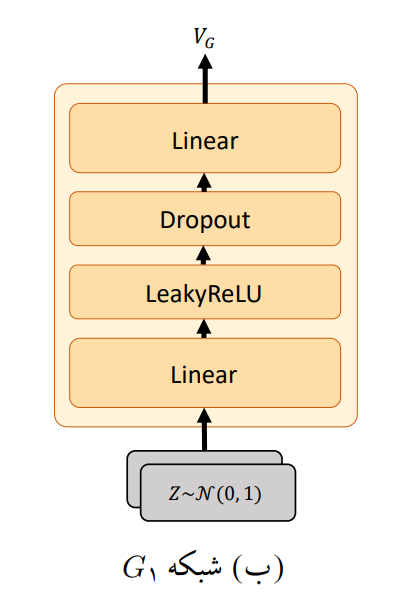

In [6]:
class Generator_1(nn.Module):
    def __init__(self, d_in = d_in, d_out = d_out, p_dropout = p_dropout):
        super(Generator_1, self).__init__()

        self.layer1 = nn.Linear(d_in, d_out)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(p=p_dropout)
        self.layer2 = nn.Linear(d_out, d_out)

    def forward(self, latent_vector):

        v_G = self.layer1(latent_vector)
        v_G = self.leaky_relu(v_G)
        v_G = self.dropout(v_G)
        v_G = self.layer2(v_G)
        return v_G


## Discriminator

### Input

The `forward` method takes a tensor (`input`) of shape `(batch_size, input_dim)` representing features for evaluation.

### Forward Method

The forward method applies the following operations sequentially:

1. **Dropout Layer 1:**
   - Applies dropout (`p_dropout`) for regularization.

2. **Linear Layer 1:**
   - Fully connected layer transforming the tensor to `d_out` shape.

3. **Leaky ReLU Activation:**
   - Introduces non-linearity with leaky ReLU.

4. **Dropout Layer 2:**
   - Additional dropout for regularization.

5. **Linear Layer 2:**
   - Produces final output for classification.

6. **Softmax Activation:**
   - Computes class probabilities.

### Output

- **\_features:** Output after dropout and first linear layer.
- **logits:** Unnormalized predictions.
- **probs:** Class probabilities.

Designed for binary classification (`1 + n_class_dataset` classes), extendable to multiple classes.


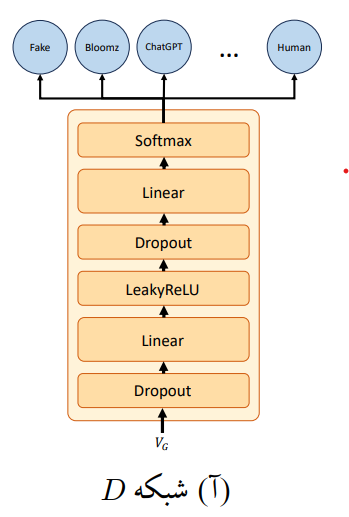

In [7]:
class Discriminator(nn.Module):
    def __init__(self, d_out = d_out, p_dropout = p_dropout, n_class_dataset = n_class_dataset):
        super(Discriminator, self).__init__()

        self.dropout1 = nn.Dropout(p=p_dropout)
        self.linear1 = nn.Linear(d_out, d_out)

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(p=p_dropout)
        self.linear2 = nn.Linear(d_out, 1 + n_class_dataset)

    def forward(self, input):
        features = self.dropout1(input)
        _features = self.linear1(features)

        features = self.leaky_relu(_features)
        features = self.dropout2(features)
        logits = self.linear2(features)

        return  logits,_features

The reason for not using a separate softmax layer is that it is implicitly incorporated in the `nn.CrossEntropyLoss` function in PyTorch.


## Bert Block


In [8]:
def BERT_Block(text, tokenizer, model, device):

    input = tokenizer(text,
                            return_tensors='pt',
                            truncation=True,
                            padding=True,
                            max_length = max_length).to(device)
    with torch.no_grad():
        output = model(**input, output_hidden_states=True)

    # Extract the last hidden states and the [CLS] token representation
    hidden_states = output.hidden_states[-1]
    CLS = hidden_states[:, 0, :]

    return CLS


# GAN-Bert Model

## Model Initialization

We instantiate a BERT-based tokenizer using the Hugging Face Transformers library and initialize four sets of models and generators for different labeled data percentages (1%, 5%, 10%, and 50%).

Two different loss functions are defined - `nn.BCEWithLogitsLoss` for the generator and discriminator and `nn.CrossEntropyLoss` for calculating the criterion scores.


In [10]:
random.seed(Seed)
np.random.seed(Seed)
torch.manual_seed(Seed)
set_seed(Seed)

tokenizer = AutoTokenizer.from_pretrained(model_name)

modelBERT_OnePercent = utilityG.initialize_model_Bert(model_name, device)
G_OnePercent = Generator_1().to(device)
D_OnePercent = Discriminator().to(device)

modelBERT_FivePercent = utilityG.initialize_model_Bert(model_name, device)
G_FivePercent = Generator_1().to(device)
D_FivePercent = Discriminator().to(device)

modelBERT_TenPercent = utilityG.initialize_model_Bert(model_name, device)
G_TenPercent = Generator_1().to(device)
D_TenPercent = Discriminator().to(device)


modelBERT_FiftyPercent = utilityG.initialize_model_Bert(model_name, device)
G_FiftyPercent = Generator_1().to(device)
D_FiftyPercent = Discriminator().to(device)

criterion_G = nn.BCEWithLogitsLoss()
criterion_sup = nn.CrossEntropyLoss()

# Validation Dataset
dataset_val=utilityG.GanBertDataset(Percentage=100, Dataset_Name ='Dev', Seed=42, Download_Dataset = True)
val_loader =  DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


accuracies= []

## Dateset and DataLoader

## Training Model with 1% Labeled Data

In this section, we prepare and visualize 1% of the labeled training and validation data, then train the GAN_BERT classification model.

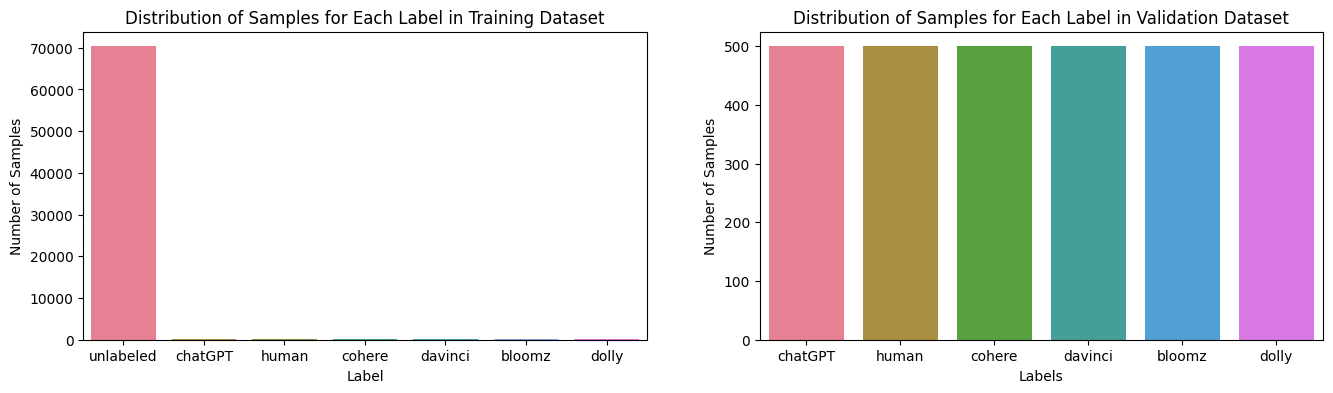


Label Counts for Training Dataset:
unlabeled: 70317
chatGPT: 130
human: 109
cohere: 108
davinci: 111
bloomz: 115
dolly: 137

Label Counts for Validation Dataset:
chatGPT: 500
human: 500
cohere: 500
davinci: 500
bloomz: 500
dolly: 500





In [11]:
dataset_train_Onepercent=utilityG.GanBertDataset(Percentage=1, Dataset_Name ='Train', Seed=42, Download_Dataset = True)
train_loader_Onepercent =  DataLoader(dataset_train_Onepercent, batch_size=batch_size, shuffle=True)

utilityG.distribution_plot(dataset_train_Onepercent, dataset_val, 'Part_Three_G1_onePercent_distribution_plot.png')

bert = [i for i in modelBERT_OnePercent.parameters()]
d_vars = bert + [v for v in D_OnePercent.parameters()]
optimizer_D_one = optim.Adam(d_vars, lr=learning_rate, betas=(0.9, 0.999))
optimizer_G_one = optim.Adam(G_OnePercent.parameters(), lr=learning_rate, betas=(0.9, 0.999))


100%|██████████| 1110/1110 [05:27<00:00,  3.39it/s]


Epoch 1/5 | G_loss: 0.7103 | D_loss: 1.7579  | Val_Accuracy: 28.43
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:23<00:00,  3.43it/s]


Epoch 2/5 | G_loss: 0.7044 | D_loss: 1.6020  | Val_Accuracy: 25.60


100%|██████████| 1110/1110 [05:23<00:00,  3.43it/s]


Epoch 3/5 | G_loss: 0.7024 | D_loss: 1.5300  | Val_Accuracy: 31.50
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:23<00:00,  3.44it/s]


Epoch 4/5 | G_loss: 0.7020 | D_loss: 1.4507  | Val_Accuracy: 32.07
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:23<00:00,  3.43it/s]


Epoch 5/5 | G_loss: 0.7021 | D_loss: 1.3782  | Val_Accuracy: 38.17
Best Model saved to Google Drive


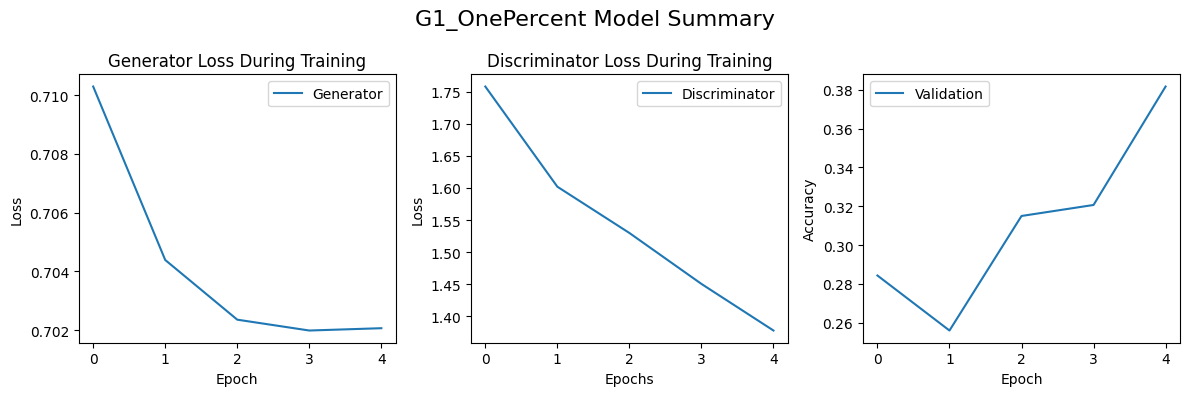

saved Best_Model loaded
Accuracy on Validation dataset is: 38.17


In [12]:
G1_OnePercent = utilityG.model_train(model_Bert = modelBERT_OnePercent,
                               Discriminator = D_OnePercent,
                               Generator = G_OnePercent,
                               kind_G='G1',
                               BERT_Block = BERT_Block,
                               optimizer_D = optimizer_D_one,
                               optimizer_G = optimizer_G_one,
                               criterion_sup = criterion_sup,
                               lambda_sup = lambda_sup,
                               lambda_feat = lambda_feat,
                               criterion_G = criterion_G,
                               tokenizer = tokenizer,
                               train_loader = train_loader_Onepercent,
                               val_loader = val_loader,
                               num_epochs = num_epochs,
                               device = device,
                               d_in = d_in,
                               Name='G1_OnePercent',
                               Use_save_model=False ,save_model= True)
# Train model
G1_OnePercent.train()

# get the accuracy of the model
accuracies.append(G1_OnePercent.Accuracy(loader = val_loader, Use_best_model = True))

print(f'Accuracy on Validation dataset is: {100*accuracies[-1]:.2f}')

## Training Model with 5% Labeled Data

In this section, we prepare and visualize 5% of the labeled training and validation data, then train the GAN_BERT classification model.

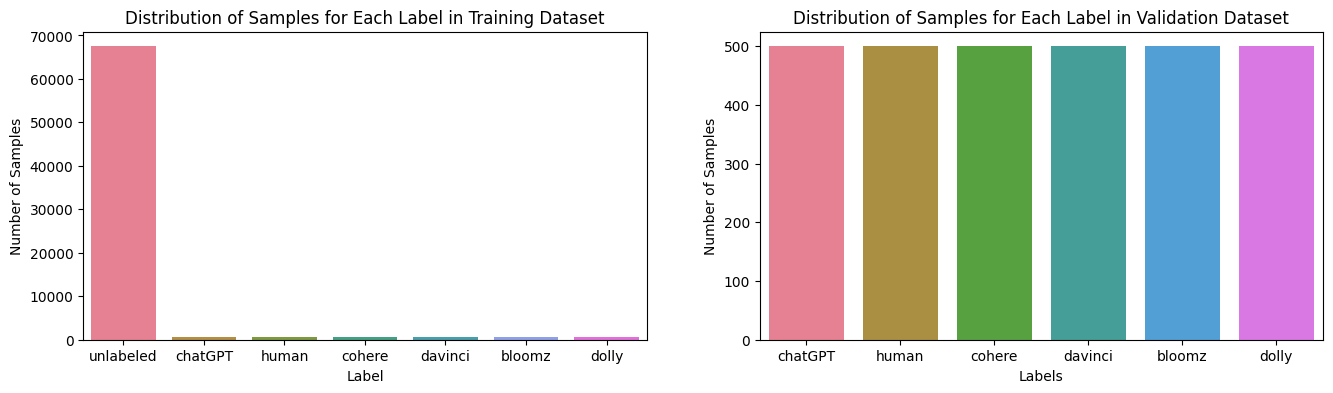


Label Counts for Training Dataset:
unlabeled: 67476
chatGPT: 626
human: 552
cohere: 561
davinci: 582
bloomz: 625
dolly: 605

Label Counts for Validation Dataset:
chatGPT: 500
human: 500
cohere: 500
davinci: 500
bloomz: 500
dolly: 500





In [13]:
dataset_train_Fivepercent=utilityG.GanBertDataset(Percentage=5, Dataset_Name ='Train', Seed=42, Download_Dataset = False)
train_loader_Fivepercent =  DataLoader(dataset_train_Fivepercent, batch_size=batch_size, shuffle=True)

utilityG.distribution_plot(dataset_train_Fivepercent, dataset_val, 'Part_Three_G1_FivePercent_distribution_plot.png')

bert = [i for i in modelBERT_FivePercent.parameters()]
d_vars = bert + [v for v in D_FivePercent.parameters()]
optimizer_D_5 = optim.Adam(d_vars, lr=learning_rate, betas=(0.9, 0.999))
optimizer_G_5 = optim.Adam(G_FivePercent.parameters(), lr=learning_rate, betas=(0.9, 0.999))

100%|██████████| 1110/1110 [05:26<00:00,  3.40it/s]


Epoch 1/5 | G_loss: 0.7099 | D_loss: 2.6717  | Val_Accuracy: 32.40
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:28<00:00,  3.38it/s]


Epoch 2/5 | G_loss: 0.7038 | D_loss: 2.4484  | Val_Accuracy: 41.07
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:27<00:00,  3.39it/s]


Epoch 3/5 | G_loss: 0.7015 | D_loss: 2.3294  | Val_Accuracy: 40.33


100%|██████████| 1110/1110 [05:26<00:00,  3.40it/s]


Epoch 4/5 | G_loss: 0.7011 | D_loss: 2.2771  | Val_Accuracy: 43.17
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:27<00:00,  3.39it/s]


Epoch 5/5 | G_loss: 0.7010 | D_loss: 2.2286  | Val_Accuracy: 43.93
Best Model saved to Google Drive


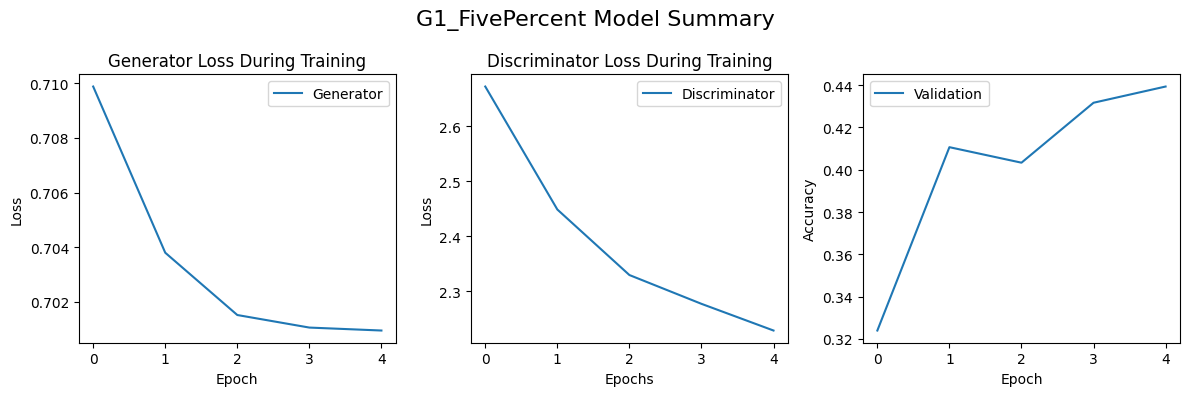

saved Best_Model loaded
Accuracy on Validation dataset is: 43.93


In [14]:
G1_FivePercent = utilityG.model_train(model_Bert = modelBERT_FivePercent,
                                 Discriminator = D_FivePercent,
                                 Generator = G_FivePercent,
                                 kind_G='G1',
                                 BERT_Block = BERT_Block,
                                 optimizer_D = optimizer_D_5,
                                 optimizer_G = optimizer_G_5,
                                 criterion_sup = criterion_sup,
                                 lambda_sup = lambda_sup,
                                 lambda_feat = lambda_feat,
                                 criterion_G = criterion_G,
                                 tokenizer = tokenizer,
                                 train_loader = train_loader_Fivepercent,
                                 val_loader = val_loader,
                                 num_epochs =num_epochs,
                                 device = device,
                                 d_in = d_in,
                                 Name='G1_FivePercent',
                                 Use_save_model=False ,save_model= True)
# Train model
G1_FivePercent.train()

# get the accuracy of the model
accuracies.append(G1_FivePercent.Accuracy(loader = val_loader, Use_best_model = True))

print(f'Accuracy on Validation dataset is: {100*accuracies[-1]:.2f}')

## Training Model with 10% Labeled Data

In this section, we prepare and visualize 10% of the labeled training and validation data, then train the GAN_BERT classification model.

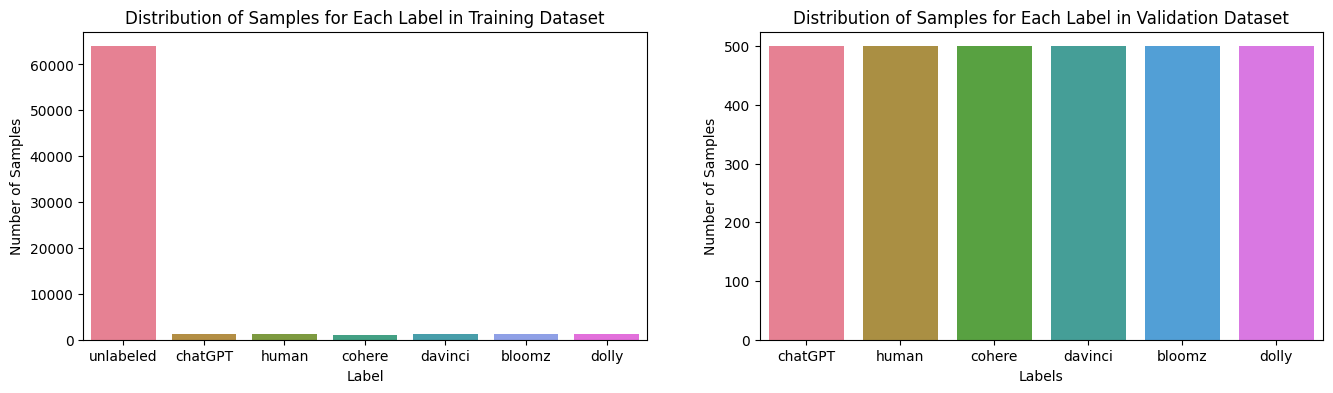


Label Counts for Training Dataset:
unlabeled: 63925
chatGPT: 1219
human: 1185
cohere: 1113
davinci: 1187
bloomz: 1226
dolly: 1172

Label Counts for Validation Dataset:
chatGPT: 500
human: 500
cohere: 500
davinci: 500
bloomz: 500
dolly: 500





In [15]:
dataset_train_Tenpercent=utilityG.GanBertDataset(Percentage=10, Dataset_Name ='Train', Seed=42, Download_Dataset = False)
train_loader_Tenpercent =  DataLoader(dataset_train_Tenpercent, batch_size=batch_size, shuffle=True)

utilityG.distribution_plot(dataset_train_Tenpercent, dataset_val, 'Part_Three_G1_TenPercent_distribution_plot.png')

bert = [i for i in modelBERT_TenPercent.parameters()]
d_vars = bert + [v for v in D_TenPercent.parameters()]
optimizer_D_10 = optim.Adam(d_vars, lr=learning_rate, betas=(0.9, 0.999))
optimizer_G_10 = optim.Adam(G_TenPercent.parameters(), lr=learning_rate, betas=(0.9, 0.999))

100%|██████████| 1110/1110 [05:31<00:00,  3.35it/s]


Epoch 1/5 | G_loss: 0.7101 | D_loss: 2.6551  | Val_Accuracy: 39.23
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:29<00:00,  3.36it/s]


Epoch 2/5 | G_loss: 0.7030 | D_loss: 2.4466  | Val_Accuracy: 46.57
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:26<00:00,  3.40it/s]


Epoch 3/5 | G_loss: 0.7010 | D_loss: 2.3448  | Val_Accuracy: 46.50


100%|██████████| 1110/1110 [05:27<00:00,  3.39it/s]


Epoch 4/5 | G_loss: 0.7005 | D_loss: 2.2984  | Val_Accuracy: 48.53
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:28<00:00,  3.38it/s]


Epoch 5/5 | G_loss: 0.7010 | D_loss: 2.2619  | Val_Accuracy: 50.20
Best Model saved to Google Drive


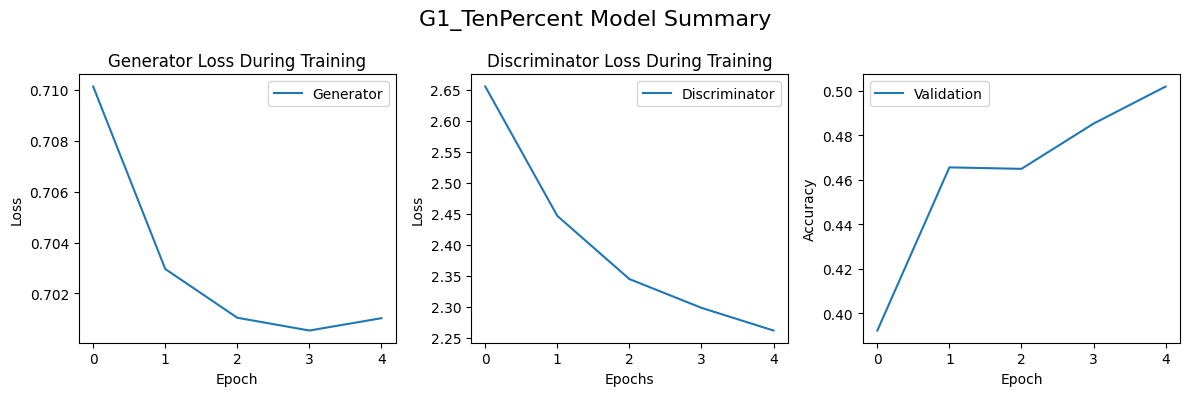

saved Best_Model loaded
Accuracy on Validation dataset is: 50.20


In [16]:
G1_TenPercent = utilityG.model_train(model_Bert = modelBERT_TenPercent,
                                    Discriminator = D_TenPercent,
                                    Generator = G_TenPercent,
                                    kind_G='G1',
                                    BERT_Block = BERT_Block,
                                    optimizer_D = optimizer_D_10,
                                    optimizer_G = optimizer_G_10,
                                    criterion_sup = criterion_sup,
                                    lambda_sup = lambda_sup,
                                    lambda_feat = lambda_feat,
                                    criterion_G = criterion_G,
                                    tokenizer = tokenizer,
                                    train_loader = train_loader_Tenpercent,
                                    val_loader = val_loader,
                                    num_epochs =num_epochs,
                                    device = device,
                                    d_in = d_in,
                                    Name='G1_TenPercent',
                                    Use_save_model=False ,save_model= True)
# Train model
G1_TenPercent.train()

# get the accuracy of the model
accuracies.append(G1_TenPercent.Accuracy(loader = val_loader, Use_best_model = True))

print(f'Accuracy on Validation dataset is: {100*accuracies[-1]:.2f}')

## Training Model with 50% Labeled Data

In this section, we prepare and visualize 50% of the labeled training and validation data, then train the GAN_BERT classification model.

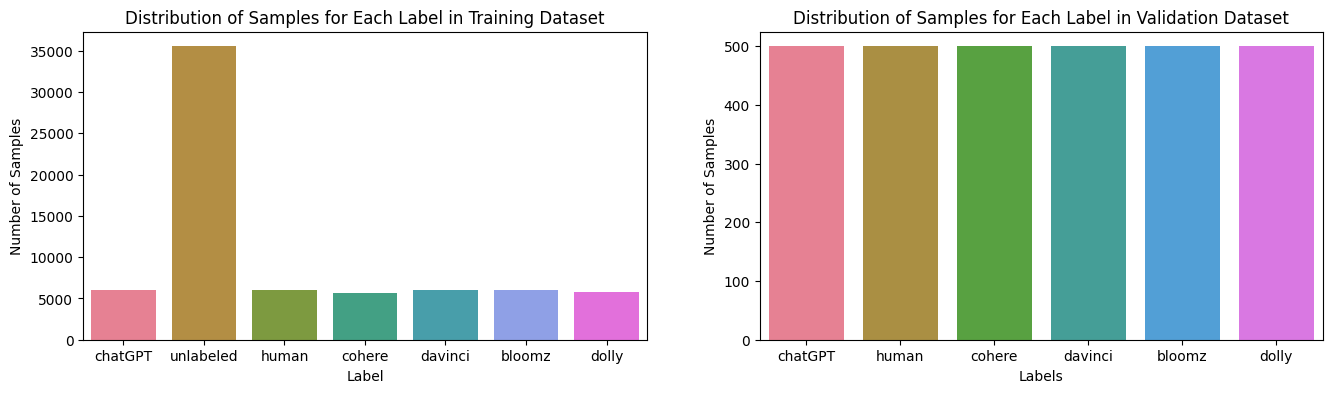


Label Counts for Training Dataset:
chatGPT: 6067
unlabeled: 35514
human: 6012
cohere: 5631
davinci: 5992
bloomz: 6007
dolly: 5804

Label Counts for Validation Dataset:
chatGPT: 500
human: 500
cohere: 500
davinci: 500
bloomz: 500
dolly: 500





In [17]:
dataset_train_Fiftypercent=utilityG.GanBertDataset(Percentage=50, Dataset_Name ='Train', Seed=42, Download_Dataset = False)
train_loader_Fiftypercent =  DataLoader(dataset_train_Fiftypercent, batch_size=batch_size, shuffle=True)

utilityG.distribution_plot(dataset_train_Fiftypercent, dataset_val, 'Part_Three_G1_FiftyPercent_distribution_plot.png')

bert = [i for i in modelBERT_FiftyPercent.parameters()]
d_vars = bert + [v for v in D_FiftyPercent.parameters()]
optimizer_D_50 = optim.Adam(d_vars, lr=learning_rate, betas=(0.9, 0.999))
optimizer_G_50 = optim.Adam(G_FiftyPercent.parameters(), lr=learning_rate, betas=(0.9, 0.999))

100%|██████████| 1110/1110 [05:27<00:00,  3.39it/s]


Epoch 1/5 | G_loss: 0.7088 | D_loss: 2.5027  | Val_Accuracy: 46.50
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:30<00:00,  3.36it/s]


Epoch 2/5 | G_loss: 0.7004 | D_loss: 2.3133  | Val_Accuracy: 51.13
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:28<00:00,  3.38it/s]


Epoch 3/5 | G_loss: 0.6995 | D_loss: 2.2482  | Val_Accuracy: 54.23
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:28<00:00,  3.38it/s]


Epoch 4/5 | G_loss: 0.7004 | D_loss: 2.2039  | Val_Accuracy: 56.53
Best Model saved to Google Drive


100%|██████████| 1110/1110 [05:28<00:00,  3.38it/s]


Epoch 5/5 | G_loss: 0.7011 | D_loss: 2.1720  | Val_Accuracy: 56.40


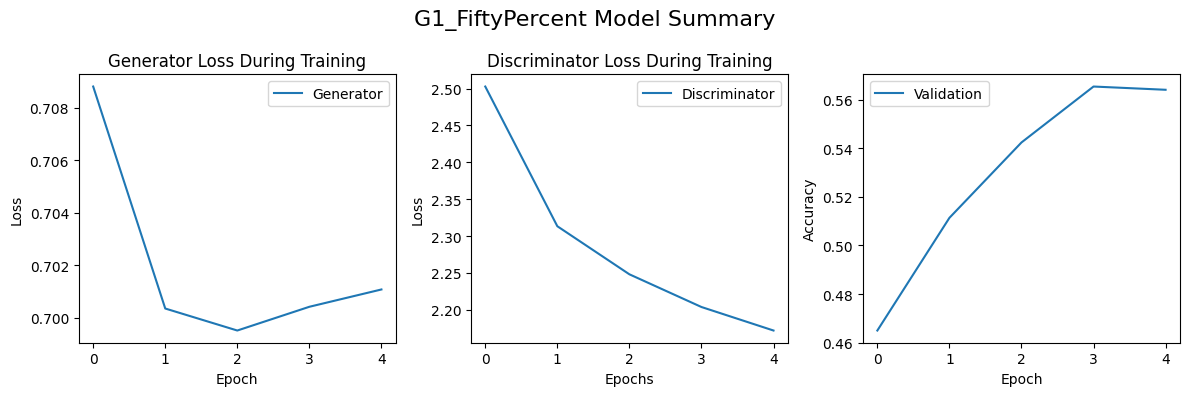

saved Best_Model loaded
Accuracy on Validation dataset is: 56.53


In [18]:
G1_FiftyPercent = utilityG.model_train(model_Bert = modelBERT_FiftyPercent,
                                        Discriminator = D_FiftyPercent,
                                        Generator = G_FiftyPercent,
                                        kind_G='G1',
                                        BERT_Block = BERT_Block,
                                        optimizer_D = optimizer_D_50,
                                        optimizer_G = optimizer_G_50,
                                        criterion_sup = criterion_sup,
                                        lambda_sup = lambda_sup,
                                        lambda_feat = lambda_feat,
                                        criterion_G = criterion_G,
                                        tokenizer = tokenizer,
                                        train_loader = train_loader_Fiftypercent,
                                        val_loader = val_loader,
                                        num_epochs =num_epochs,
                                        device = device,
                                        d_in = d_in,
                                        Name='G1_FiftyPercent',
                                        Use_save_model=False ,save_model= True)
# Train model
G1_FiftyPercent.train()

# get the accuracy of the model
accuracies.append(G1_FiftyPercent.Accuracy(loader = val_loader, Use_best_model = True))

print(f'Accuracy on Validation dataset is: {100*accuracies[-1]:.2f}')

## Plotting Accuracy vs. Percentage of Labeled Data

In this section, we visualize the accuracy of the GAN-BERT classification model at different percentages of labeled data.


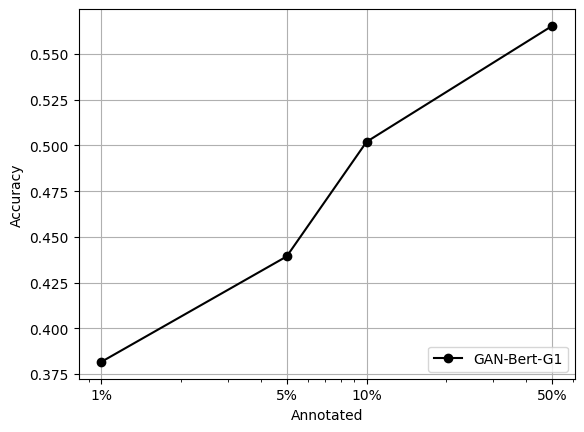

In [19]:
percentages = [1, 5, 10, 50]

utilityG.plot_accuracy_vs_percentage(percentages, accuracies, label='GAN-Bert-G1')

In [20]:
from google.colab import files

uploaded = files.upload()

Saving bert_accuracies.pkl to bert_accuracies.pkl


In [21]:
import pickle

with open('bert_accuracies.pkl', 'rb') as file:
    bert_accuracies = pickle.load(file)

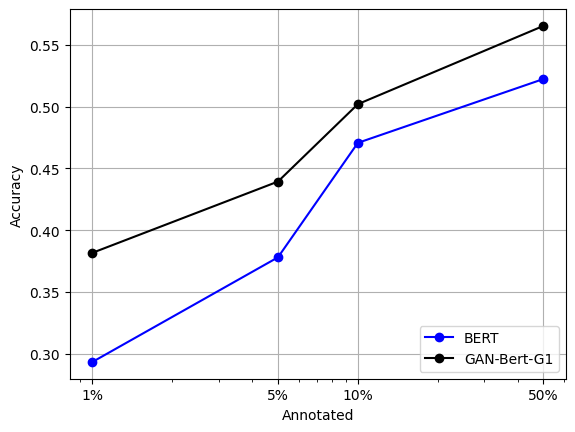

In [22]:
import matplotlib.pyplot as plt
plt.semilogx(percentages, bert_accuracies, marker='o', color='blue', label='BERT')
plt.semilogx(percentages, accuracies, marker='o', color='black', label='GAN-Bert-G1')
plt.xticks(percentages, [f"{p}%" for p in percentages])

plt.xlabel('Annotated')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('../Plots/compare-G1.png')
plt.show()

In [24]:
import pickle


with open('G1_accuracies.pkl', 'wb') as file:
    pickle.dump(accuracies, file)